## IMPORT PACKAGES

In [42]:
import numpy as np
import os
import nltk
import torch
import torch.nn
import torchtext.vocab as vocab
from sklearn import metrics
import pandas as pd
import warnings
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

## DEFINE FUNCTION

In [43]:
def load_data():
    df = pd.read_csv("D:/jupyter-workplace/classification_project/data_cleaning/product_classification_ros.csv", encoding='utf_8_sig')
    print(df.columns)
    texts = df['ProductName'].values
    df = df.fillna(-1)
    # labels = np.argmax(df[df.columns[-4:]].values, axis=1)
    labels = df['level_1'].values
    label2id = {l: i for i, l in enumerate(set(labels))}
    id2label = {i: l for l, i in label2id.items()}
    labels = [label2id[l] for l in labels]
    return texts, labels, id2label

In [44]:
def text_preprocess(text):
    text = str(text)
    english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '\'', '/']
    text = "".join([(a if a not in english_punctuations else " ") for a in text])
    text = " ".join(nltk.tokenize.word_tokenize(text.lower()))
    return text

In [45]:
def evaluation(predictions, labels, id2label, model_name=None):
    acc = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")
    report = metrics.classification_report(labels, predictions,
                                           target_names=[id2label[i] for i in range(len(id2label))])
    info = "acc:%s, recall:%s, f1 score:%s" % (acc, recall, f1)
    if model_name is not None:
        info = "%s: %s" % (model_name, info)
    print(info)
    print(report)

## Data Processing

In [46]:
texts, labels, id2label = load_data()  
texts = [text_preprocess(t) for t in texts]

Index(['ProductName', 'level_1', 'level_2', 'level_3'], dtype='object')


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vectorizer = TfidfVectorizer() 
features=vectorizer.fit_transform(texts)
print("data len:", len(texts))
print("id2label",id2label)

data len: 41250
id2label {0: 'Personal Care', 1: 'Baby, Toddler & Kids', 2: 'Kitchen, Dining & Household', 3: 'Chilled, Frozen & Desserts', 4: 'Featured', 5: 'Fresh Foods & Bakery', 6: 'Meal Spot', 7: 'Pantry', 8: 'Beer, Cider & Wine', 9: 'Drinks', 10: 'Pets'}


In [48]:
#测试集划分
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25,
                                                                            random_state=3)

## 预跑模型

## Logistic Regression

In [49]:
#Logistic Regression
model = LogisticRegression()
model.fit(x_train, y_train)
predict_labels = model.predict(x_test)
# print(predict_labels)
predict_labels = [np.round(p) for p in predict_labels]
max_label = len(id2label) - 1
predict_labels = [l if max_label >= l else max_label for l in predict_labels]
min_label = 0
predict_labels = [l if min_label <= l else min_label for l in predict_labels]
evaluation(predict_labels, y_test,id2label, "logistic")

logistic: acc:0.9807039658683215, recall:0.9808419206371245, f1 score:0.9807019252033264
                             precision    recall  f1-score   support

              Personal Care       0.99      0.98      0.98       942
       Baby, Toddler & Kids       1.00      1.00      1.00       931
Kitchen, Dining & Household       0.99      0.98      0.99       911
 Chilled, Frozen & Desserts       0.96      0.97      0.97       951
                   Featured       0.97      1.00      0.98       930
       Fresh Foods & Bakery       0.97      0.96      0.96       943
                  Meal Spot       0.98      1.00      0.99       941
                     Pantry       0.95      0.91      0.93       949
         Beer, Cider & Wine       1.00      1.00      1.00       929
                     Drinks       0.99      0.99      0.99       953
                       Pets       1.00      1.00      1.00       933

                   accuracy                           0.98     10313
            

## KNN

In [50]:
#KNN
k = len(id2label)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(x_train, y_train)
knn_predict_labels = model.predict(x_test)
evaluation(knn_predict_labels, y_test, id2label, "knn")

knn: acc:0.9501599922428003, recall:0.950448910368802, f1 score:0.949232836029929
                             precision    recall  f1-score   support

              Personal Care       0.98      0.93      0.95       942
       Baby, Toddler & Kids       0.96      1.00      0.98       931
Kitchen, Dining & Household       0.96      0.95      0.96       911
 Chilled, Frozen & Desserts       0.93      0.92      0.93       951
                   Featured       0.92      1.00      0.96       930
       Fresh Foods & Bakery       0.91      0.94      0.92       943
                  Meal Spot       0.94      1.00      0.97       941
                     Pantry       0.94      0.76      0.84       949
         Beer, Cider & Wine       0.98      0.98      0.98       929
                     Drinks       0.95      0.99      0.97       953
                       Pets       0.97      0.99      0.98       933

                   accuracy                           0.95     10313
                  m

## 寻找最佳K值

The optimal number of neighbors is 1


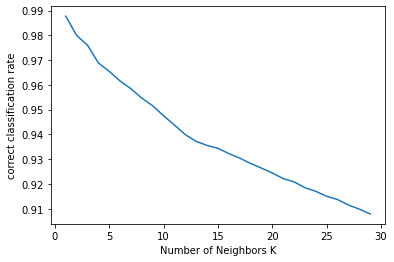

In [51]:
from sklearn.model_selection import cross_val_score
def knn_cross_validation(x_train, y_train):
    k_list = list(range(1, 30))
    list_scores = []

    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
        list_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in list_scores]
    optimal_k = k_list[MSE.index(min(MSE))]
    print ("The optimal number of neighbors is %d" % optimal_k)
    # plot misclassification error vs k
    # plt.plot(k_lst, MSE)
    # plt.ylabel('Misclassification Error')
    plt.plot(k_list, list_scores)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('correct classification rate')
    plt.show()
    return optimal_k

k = knn_cross_validation(x_train, y_train)

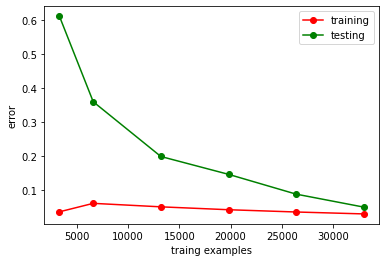

In [52]:
knn = KNeighborsClassifier(n_neighbors=9)
train_sizes,train_score,test_score = learning_curve(knn,features, labels,cv=5, scoring='accuracy', train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

train_sizes,train_score,test_score = learning_curve(knn,features,labels,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

## SVM

In [53]:
#undersamled
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

model = OneVsRestClassifier(SVC())
model.fit(x_train, y_train)
predict_labels = model.predict(x_test)
evaluation(predict_labels, y_test, id2label, "svm")

svm: acc:0.9908852904101619, recall:0.9909714168332218, f1 score:0.9908867376774417
                             precision    recall  f1-score   support

              Personal Care       0.99      0.99      0.99       942
       Baby, Toddler & Kids       1.00      1.00      1.00       931
Kitchen, Dining & Household       1.00      1.00      1.00       911
 Chilled, Frozen & Desserts       0.98      0.99      0.99       951
                   Featured       0.99      1.00      0.99       930
       Fresh Foods & Bakery       0.98      0.98      0.98       943
                  Meal Spot       0.99      1.00      0.99       941
                     Pantry       0.98      0.94      0.96       949
         Beer, Cider & Wine       1.00      1.00      1.00       929
                     Drinks       0.99      1.00      1.00       953
                       Pets       1.00      1.00      1.00       933

                   accuracy                           0.99     10313
                 

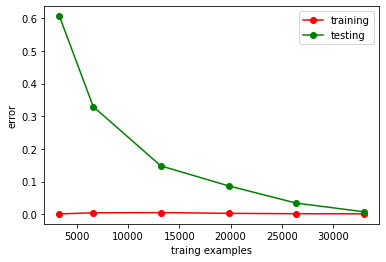

In [54]:
train_sizes,train_score,test_score = learning_curve(SVC(),features,labels,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

## SVM-gridSearch寻找最优参数

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.008 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.008 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.892 (+/-0.011) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.008 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.969 (+/-0.003) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.892 (+/-0.011) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.002) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.969 (+/-0.003) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.986 (+/-0.002) for {'C': 1, 'kernel': 'linear'}
0.989 (+/-0.002) for {'C': 10, 'kernel': 'linear'}
0.988 (+/-0.002) for {'C': 100, 'kernel': 'linear'}
0.988 (+/-0.002) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full ev

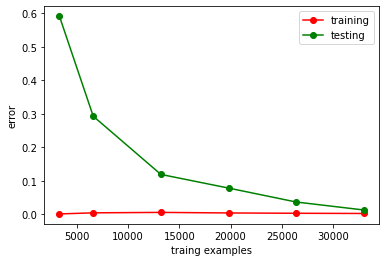

In [57]:
train_sizes,train_score,test_score = learning_curve(SVC(C=1000, gamma=0.001, kernel='rbf'),features,labels,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

In [58]:
# undersampled
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(SVC(C=1000, gamma=0.001, kernel='rbf'))
model.fit(x_train, y_train) 
svm_predict_labels = model.predict(x_test)
evaluation(svm_predict_labels, y_test, id2label, "svm")

svm: acc:0.9856491806457869, recall:0.9857806463544254, f1 score:0.9856091415922676
                             precision    recall  f1-score   support

              Personal Care       0.99      0.99      0.99       942
       Baby, Toddler & Kids       1.00      1.00      1.00       931
Kitchen, Dining & Household       0.99      0.99      0.99       911
 Chilled, Frozen & Desserts       0.97      0.97      0.97       951
                   Featured       0.97      1.00      0.99       930
       Fresh Foods & Bakery       0.97      0.98      0.98       943
                  Meal Spot       0.99      1.00      1.00       941
                     Pantry       0.97      0.91      0.94       949
         Beer, Cider & Wine       1.00      1.00      1.00       929
                     Drinks       0.99      1.00      1.00       953
                       Pets       1.00      1.00      1.00       933

                   accuracy                           0.99     10313
                 

## LightGBM with GBDT

In [59]:
import lightgbm as lgb

def lgb_model(x_train, x_test, y_train, y_test, verbose):
    params = {'num_leaves': 60,
    'min_data_in_leaf': 30,
    'objective': 'multiclass',
    'num_class': 33,
    'max_depth': 7,
    'learning_rate': 0.03,
    "min_sum_hessian_in_leaf": 6,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.8,
    "bagging_seed": 11,
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 15,
    'metric': 'multi_error',
    "random_state": 2020
          }

    evals_result = {}
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)
    model = lgb.train(params
                      , lgb_train
                      , num_boost_round = 100000
                      , valid_sets = [lgb_train, lgb_test]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , evals_result=evals_result
                     )

    print('Predicting...') 
    y_prob = model.predict(x_test, num_iteration=model.best_iteration)
    lgb_predict_labels = [list(x).index(max(x)) for x in y_prob]
    print("AUC score: {:<8.5f}".format(metrics.accuracy_score(lgb_predict_labels, y_test)))
    report = metrics.classification_report(y_test, lgb_predict_labels, target_names=[id2label[i] for i in range(len(id2label))])
    print(report)
    return model, evals_result

In [60]:
model, evals_result = lgb_model(x_train, x_test, y_train, y_test, verbose=False)

Predicting...
AUC score: 0.92301 
                             precision    recall  f1-score   support

              Personal Care       0.93      0.90      0.92       942
       Baby, Toddler & Kids       0.99      0.97      0.98       931
Kitchen, Dining & Household       0.73      0.94      0.82       911
 Chilled, Frozen & Desserts       0.89      0.88      0.89       951
                   Featured       0.99      1.00      1.00       930
       Fresh Foods & Bakery       0.93      0.88      0.90       943
                  Meal Spot       0.98      0.96      0.97       941
                     Pantry       0.84      0.77      0.80       949
         Beer, Cider & Wine       0.96      0.91      0.94       929
                     Drinks       0.97      0.96      0.96       953
                       Pets       1.00      0.98      0.99       933

                   accuracy                           0.92     10313
                  macro avg       0.93      0.92      0.92     1031

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='multi_error'>

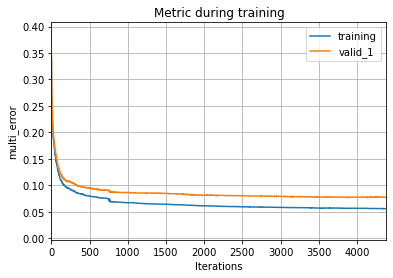

In [61]:
lgb.plot_metric(evals_result)